<a href="https://colab.research.google.com/github/metalun4/tr_eng_translator_model/blob/main/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf
!pip install tensorflow_text
import tensorflow_text as text

from keras import models, layers, optimizers, losses

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
examples, metadata = tfds.load('ted_hrlr_translate/tr_to_en',
                               with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

In [3]:
!unzip ted_hrlr_translate_tr_en_converter.zip
tokenizers = tf.saved_model.load('ted_hrlr_translate_tr_en_converter')

Archive:  ted_hrlr_translate_tr_en_converter.zip
replace ted_hrlr_translate_tr_en_converter/assets/en_vocab.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ted_hrlr_translate_tr_en_converter/assets/tr_vocab.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ted_hrlr_translate_tr_en_converter/saved_model.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ted_hrlr_translate_tr_en_converter/variables/variables.data-00000-of-00001? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ted_hrlr_translate_tr_en_converter/variables/variables.index? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [4]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [5]:
lengths = []

for tr_examples, en_examples in train_examples.batch(1024):
  tr_tokens = tokenizers.tr.tokenize(tr_examples)
  lengths.append(tr_tokens.row_lengths())

  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  print('.', end='', flush=True)

...................................................................................................................................................................................

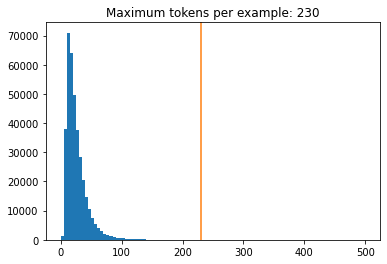

In [6]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

In [7]:
MAX_TOKENS=128
def prepare_batch(tr, en):
    tr = tokenizers.tr.tokenize(tr)      # Output is ragged.
    tr = tr[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    tr = tr.to_tensor()  # Convert to 0-padded dense Tensor

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()  # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor()   # Drop the [START] tokens

    return (tr, en_inputs), en_labels

In [8]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [9]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [10]:
# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [11]:
for (tr, en), en_labels in train_batches.take(1):
  break

print(tr.shape)
print(en.shape)
print(en_labels.shape)

(64, 77)
(64, 85)
(64, 85)


In [12]:
def positional_encoding(length, detrh):
  detrh = detrh/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  detrhs = np.arange(detrh)[np.newaxis, :]/detrh   # (1, detrh)

  angle_rates = 1 / (10000**detrhs)         # (1, detrh)
  angle_rads = positions * angle_rates      # (pos, detrh)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

(2048, 512)


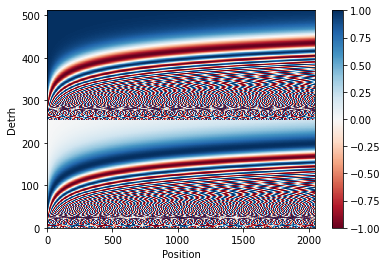

In [13]:
pos_encoding = positional_encoding(length=2048, detrh=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Detrh')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [14]:
class PositionalEmbedding(layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, detrh=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [15]:
embed_tr = PositionalEmbedding(vocab_size=tokenizers.tr.get_vocab_size(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size(), d_model=512)

tr_emb = embed_tr(tr)
en_emb = embed_en(en)


In [16]:
class BaseAttention(layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = layers.MultiHeadAttention(**kwargs)
    self.layernorm = layers.LayerNormalization()
    self.add = layers.Add()

In [17]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [18]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [19]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [20]:
class FeedForward(layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = models.Sequential([
      layers.Dense(dff, activation='relu'),
      layers.Dense(d_model),
      layers.Dropout(dropout_rate)
    ])
    self.add = layers.Add()
    self.layer_norm = layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

In [21]:
class EncoderLayer(layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [22]:
class Encoder(layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [23]:
class DecoderLayer(layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [24]:
class Decoder(layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [25]:
class Transformer(models.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

In [26]:
num_layers = 6
d_model = 128
dff = 1024
num_heads = 8
dropout_rate = 0.1

In [27]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.tr.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

In [28]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [29]:
learning_rate = CustomSchedule(d_model)

adamopt = optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [30]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [31]:
transformer.compile(
    loss=masked_loss,
    optimizer=adamopt,
    metrics=[masked_accuracy])

In [32]:

transformer.fit(train_batches,
                epochs=20,
                validation_data=val_batches)

Epoch 1/20
2851/2851 [==============================] - 280s 92ms/step - loss: 5.0977 - masked_accuracy: 0.2435 - val_loss: 3.8962 - val_masked_accuracy: 0.3438
Epoch 2/20
2851/2851 [==============================] - 260s 91ms/step - loss: 3.6997 - masked_accuracy: 0.3578 - val_loss: 3.1207 - val_masked_accuracy: 0.4352
Epoch 3/20
2851/2851 [==============================] - 260s 91ms/step - loss: 3.0982 - masked_accuracy: 0.4260 - val_loss: 2.7400 - val_masked_accuracy: 0.4844
Epoch 4/20
2851/2851 [==============================] - 261s 91ms/step - loss: 2.7826 - masked_accuracy: 0.4655 - val_loss: 2.5461 - val_masked_accuracy: 0.5104
Epoch 5/20
2851/2851 [==============================] - 261s 91ms/step - loss: 2.5947 - masked_accuracy: 0.4909 - val_loss: 2.4243 - val_masked_accuracy: 0.5280
Epoch 6/20
2851/2851 [==============================] - 260s 91ms/step - loss: 2.4627 - masked_accuracy: 0.5095 - val_loss: 2.3382 - val_masked_accuracy: 0.5427
Epoch 7/20
2851/2851 [============

In [33]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.tr.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

In [34]:
translator = Translator(tokenizers, transformer)

In [35]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [36]:
sentence = 'Muhteşem bir macera sizi bekliyor.'
ground_truth = 'An amazing adventure awaits you.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : Muhteşem bir macera sizi bekliyor.
Prediction     : a wonderful adventure is waiting for you .
Ground truth   : An amazing adventure awaits you.


In [37]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [38]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([9, 10])

In [39]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.tr.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.tr.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'[START]', b'muhtesem', b'bir', b'm', b'##ac', b'##era', b'sizi',
       b'bekliyor', b'.', b'[END]'], dtype=object)>

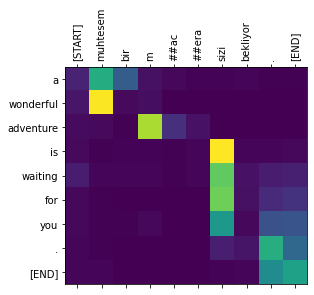

In [40]:
plot_attention_head(in_tokens, translated_tokens, attention)